<a href="https://colab.research.google.com/github/Sanarazaaa/Predicting-Phylogenetic-Match-Types-Using-Graph-Based-Machine-Learning/blob/main/Predicting_Phylogenetic_Match_Types_Using_Graph_Based_Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import pandas as pd
import networkx as nx
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
import Levenshtein

# Load CSV
df = pd.read_csv('/content/BirdLife-BirdTree crosswalk.csv')

# Fill NaNs with empty string and convert to string type
df['Species1'] = df['Species1'].fillna('').astype(str)
df['Species3'] = df['Species3'].fillna('').astype(str)
df['Match.type'] = df['Match.type'].fillna('').astype(str)

# Build graph
G = nx.Graph()
for _, row in df.iterrows():
    G.add_edge(row['Species1'], row['Species3'], match_type=row['Match.type'])

# Approximate betweenness
bet_centrality = nx.betweenness_centrality(G, k=500, normalized=True, seed=42)
clos_centrality = nx.closeness_centrality(G)

edges_features = []
labels = []

for u, v, data in G.edges(data=True):
    deg_u = G.degree(u)
    deg_v = G.degree(v)
    bet_u = bet_centrality[u]
    bet_v = bet_centrality[v]
    clos_u = clos_centrality[u]
    clos_v = clos_centrality[v]

    # Ensure strings
    u_str = str(u)
    v_str = str(v)

    lev_sim = Levenshtein.ratio(u_str, v_str)

    # Genus comparison (safe)
    genus_same = int(u_str.split()[0] == v_str.split()[0]) if u_str and v_str else 0

    features = [deg_u, deg_v, bet_u, bet_v, clos_u, clos_v, lev_sim, genus_same]
    edges_features.append(features)
    labels.append(data['match_type'])

# Encode labels
le = LabelEncoder()
y = le.fit_transform(labels)
X = edges_features

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Predict and evaluate
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=le.classes_))


                         precision    recall  f1-score   support

                              0.00      0.00      0.00         1
             1BL to 1BT       1.00      1.00      1.00      1787
         1BL to many BT       0.30      0.05      0.08        61
                Extinct       0.85      1.00      0.92        29
          Invalid taxon       0.00      0.00      0.00         1
         Many BL to 1BT       0.86      0.98      0.92       376
Newly described species       0.00      0.00      0.00         3

               accuracy                           0.97      2258
              macro avg       0.43      0.43      0.42      2258
           weighted avg       0.95      0.97      0.96      2258



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [15]:
import pandas as pd

# Assuming your dataframe is df and the class column is 'Match.type'
class_counts = df['Match.type'].value_counts()
print(class_counts)


Match.type
1BL to 1BT                 8960
Many BL to 1BT             1933
1BL to many BT              225
Extinct                     143
Newly described species      24
Invalid taxon                 4
Other                         2
Name: count, dtype: int64


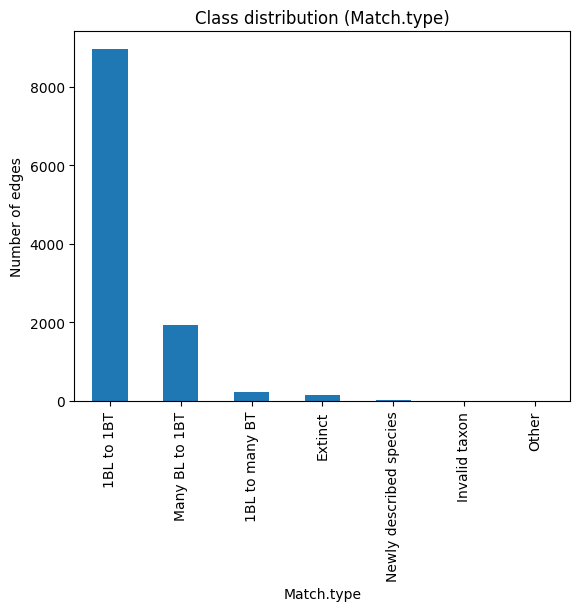

In [16]:
import matplotlib.pyplot as plt

class_counts.plot(kind='bar')
plt.ylabel('Number of edges')
plt.title('Class distribution (Match.type)')
plt.show()


In [14]:
import pandas as pd
import networkx as nx
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
import Levenshtein
from imblearn.over_sampling import SMOTE
from collections import Counter

# Load CSV
df = pd.read_csv('/content/BirdLife-BirdTree crosswalk.csv')

# Fill NaNs and convert to string
df['Species1'] = df['Species1'].fillna('').astype(str)
df['Species3'] = df['Species3'].fillna('').astype(str)
df['Match.type'] = df['Match.type'].fillna('').astype(str)

# Merge extremely rare classes into 'Other' (<3 samples to ensure >= 2 samples after split)
value_counts = df['Match.type'].value_counts()
df['Match.type'] = df['Match.type'].apply(lambda x: x if value_counts[x] >= 3 else 'Other')


# Build graph
G = nx.Graph()
for _, row in df.iterrows():
    # Only add edges if both species names are valid strings
    if row['Species1'] and row['Species3']:
        G.add_edge(row['Species1'], row['Species3'], match_type=row['Match.type'])


# Approximate betweenness and closeness for speed
bet_centrality = nx.betweenness_centrality(G, k=min(len(G), 500), normalized=True, seed=42)
clos_centrality = nx.closeness_centrality(G)


# Compute edge features
edges_features = []
labels = []

for u, v, data in G.edges(data=True):
    # Ensure nodes exist in centrality dictionaries before accessing
    if u in bet_centrality and v in bet_centrality and u in clos_centrality and v in clos_centrality:
        deg_u = G.degree(u)
        deg_v = G.degree(v)
        bet_u = bet_centrality[u]
        bet_v = bet_centrality[v]
        clos_u = clos_centrality[u]
        clos_v = clos_centrality[v]

        u_str = str(u)
        v_str = str(v)

        lev_sim = Levenshtein.ratio(u_str, v_str)
        genus_same = int(u_str.split()[0] == v_str.split()[0]) if u_str and v_str else 0


        features = [deg_u, deg_v, bet_u, bet_v, clos_u, clos_v, lev_sim, genus_same]
        edges_features.append(features)
        labels.append(data['match_type'])

# Encode labels
le = LabelEncoder()
y = le.fit_transform(labels)
X = edges_features

# Train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Adaptive SMOTE: adjust k_neighbors for smallest class
counter = Counter(y_train)
min_samples = min(counter.values())
k_neighbors = min(5, min_samples - 1) if min_samples > 1 else 1

sm = SMOTE(random_state=42, k_neighbors=k_neighbors)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

# Train classifier with balanced class weight
clf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
clf.fit(X_train_res, y_train_res)

# Predict and evaluate
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=le.classes_, zero_division=0))

# Feature importance
importances = clf.feature_importances_
feature_names = ['deg_u','deg_v','bet_u','bet_v','clos_u','clos_v','lev_sim','genus_same']
for name, imp in zip(feature_names, importances):
    print(f"{name}: {imp:.3f}")

                precision    recall  f1-score   support

    1BL to 1BT       1.00      1.00      1.00      1792
1BL to many BT       0.15      0.67      0.25        45
Many BL to 1BT       0.93      0.58      0.71       387

      accuracy                           0.92      2224
     macro avg       0.69      0.75      0.65      2224
  weighted avg       0.97      0.92      0.93      2224

deg_u: 0.174
deg_v: 0.105
bet_u: 0.011
bet_v: 0.002
clos_u: 0.202
clos_v: 0.227
lev_sim: 0.242
genus_same: 0.038
